## Analyze A/B Test Results

### Introduction

- an e-commerce website has done a/b test experiment on their new webpage
- task: using statistics decide on 
    - use new page
    - keep the old page
    - run the experiment longer to make later decision


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

## Quiz 1

In [2]:
df = pd.read_csv("ab_data.csv")

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Use the cell below to find the number of rows in the dataset.
df.shape

(294478, 5)

In [4]:
# The number of unique users in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
df[df.converted == 1].shape[0]

35237

In [6]:
df[df.converted == 0].shape[0]

259241

In [7]:
converted_user_count = df[df.converted == 1].shape[0]

In [8]:
all_user_count = df.shape[0]

In [9]:
# portion that is converted
converted_user_count/all_user_count

0.11965919355605512

In [10]:
query_control_and_newpage ='group == "control" & landing_page == "new_page"'

In [11]:
query_treatment_and_oldpage ='group == "treatment" & landing_page == "old_page"'

In [12]:
missmatches = df.query(query_control_and_newpage + "|" +  query_treatment_and_oldpage)

In [13]:
# The number of times the `new_page` and `treatment` don't match.
missmatches.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [14]:
# rows with missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## Quiz 2

In [15]:
df2 = df

In [16]:
df2.drop(missmatches.index, inplace=True)

In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

## Quiz 3

In [18]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [19]:
df2["user_id"].duplicated().sum()

1

In [20]:
# There is one user_id** repeated in df2
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [21]:
# Remove one of the rows with a duplicate user_id, but keep your dataframe as df2
df2.drop_duplicates(subset='user_id', inplace=True)

In [22]:
df2.user_id.duplicated().sum()

0

## Quiz 4

In [23]:
# What is the probability of an individual converting regardless of the page they receive?
df2.converted.mean()

0.11959708724499628

In [24]:
# Given that an individual was in the `control` group, what is the probability they converted?
control_mean = df2[df2.group == "control"].converted.mean()
control_mean

0.1203863045004612

In [25]:
# Given that an individual was in the `treatment` group, what is the probability they converted?
treatment_mean = df2[df2.group == "treatment"].converted.mean()
treatment_mean

0.11880806551510564

In [26]:
landing_counts = df2.landing_page.value_counts()

In [27]:
landing_counts

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [28]:
# What is the probability that an individual received the new page?

landing_counts[0] /df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [29]:
treatment_mean - control_mean

-0.0015782389853555567

### Answer - e
- evidence is not enough siwtch to new treatment
- difference between control and treatment is not much
- this doesn't reject null
- we could do a bootstrapping 

<a id='ab_test'></a>
## Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### Answer 1

null hypothesis is old page is better or equal to new page

**$h_{0}$** : **$p_{old}$** - **$p_{new}$** >= 0

alternate is new page is better

**$h_{1}$** : **$p_{new}$** - **$p_{old}$** > 0


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

## Quiz 5

In [30]:
#conversion rate  for p_new under the null? 
p_new = df2.converted.mean()
p_new 

0.11959708724499628

In [31]:
#conversion rate for p_old under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [32]:
#the number of individuals in the treatment group
n_new = df2[df2.group == 'treatment'].user_id.nunique()
n_new

145310

In [33]:
# the number of individuals in the control group
n_old = df2[df2.group == 'control'].user_id.nunique()
n_old 

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])

In [35]:
new_page_converted.mean()

0.12041153396187461

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [36]:
old_page_converted = np.random.choice([1,0], n_old, p=[p_old, 1-p_old])

In [37]:
old_page_converted.mean()

0.11844514503627628

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [38]:
new_page_converted.mean() - old_page_converted.mean()

0.0019663889255983336

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [39]:
new_page_sim = np.random.binomial(n_new, p_new, 10000)/n_new

In [42]:
old_page_sim = np.random.binomial(n_old, p_old, 10000)/n_old

In [44]:
p_diffs = new_page_sim - old_page_sim

In [47]:
np.mean(p_diffs)

-6.477893543043762e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [48]:
p_diffs_np = np.array(p_diffs)

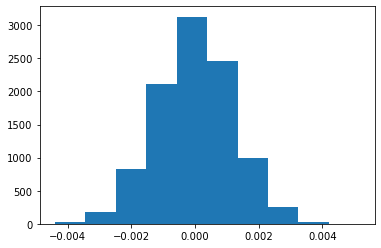

In [49]:
plt.hist(p_diffs_np);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [50]:
observed_diff = treatment_mean - control_mean
observed_diff

-0.0015782389853555567

In [51]:
null_dist = np.random.normal(0, p_diffs_np.std(), p_diffs_np.size)

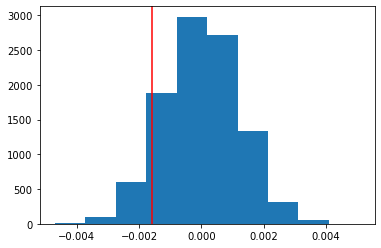

In [52]:
plt.hist(null_dist);
plt.axvline(x= observed_diff, color = 'red')

In [54]:
(null_dist > observed_diff).mean()

0.9039

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### Answer - k 

this is called p value = 0.901

for an error rate of 0.05 it is quite large

we failed to reject the null hypothesis (meaning we cant reject the idea "old page is equal or better than the new one")

therefore, we should keep using the old page

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [55]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control'")['converted'].sum()
convert_new = df2.query("group == 'treatment'")['converted'].sum()
n_old = df2.query("group == 'control'")['user_id'].count()
n_new = df2.query("group == 'treatment'")['user_id'].count()


In [56]:
convert_old, convert_new

(17489, 17264)

In [57]:
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [58]:
import statsmodels

In [59]:
zstat, p_value = statsmodels.stats.proportion.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')

In [60]:
zstat, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [61]:
from scipy.stats import norm

In [62]:
norm.cdf(1.31)

0.904902082204761

In [63]:
norm.ppf(0.95)

1.6448536269514722

### Answer - n
- p value is the same as the one calculated with bootstrapping above
- zstat is 1.31 matches cumulative distribution of p value 0.905
- 95% confidance puts the zstat 1.64
- since our zstat is not more significatn than 1.64 we failed to reject null hypothesis
- these values agree with findings in parts j and k

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### Answer - a
- we could perform logistic regression 
- Logistic regression could give a binary response (conversation/no conversation)

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [64]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [65]:
df2['intercept'] = 1

In [66]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [67]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [68]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [69]:
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [70]:
results.pvalues

intercept    0.000000
ab_page      0.189886
dtype: float64

In [71]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-03-08 19:40 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

### Answer - e
- p value of ab_page is : 0.189886
- in part 1 hypotheses were **p_old >= p_new** and alternate **p_new > p_old**
- here hypotheses is **p_old = p_new** and **p_old ≠ p_new**
- since hypotheses are different p values are different. here we are doing two sided test with logistic regression

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### Answer - f

- there could be better correlated factors out there. adding them to regression model could help us identify them. 
- they might be browser info, user properties (demographics, user type, usage type, history)
- this could lead to a better itteration next time we create a new new page.
- there might be a downside. depending on how we pick and divide the factors, we might misinterpret the success of converting with wrong factors. real reasons to trends we are searching for might disappear or diminish (paradox from the lesson) 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [72]:
df_countries = pd.read_csv("./countries.csv")

In [73]:
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [74]:
df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

### Answer - g

In [75]:
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [76]:
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [77]:
df3[['CA','UK', 'US']] = pd.get_dummies(df3.country)

In [78]:
df3.tail(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,1,0,0
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,0,1,0


In [79]:
model = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])

In [80]:
results2 = model.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [81]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-03-08 19:45 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [82]:
results2.pvalues

intercept    0.000000
CA           0.129068
UK           0.455779
dtype: float64

### Answer - g
- p values are much larger than 0.05 
- country factor doesn't have a significant impect on conversion

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [85]:
df3['CA_page'] = df3['CA'] * df3['ab_page']
df3['UK_page'] = df3['UK'] * df3['ab_page']
df3['US_page'] = df3['US'] * df3['ab_page']

In [86]:
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page,US_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [92]:
model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'US', 'CA_page', 'US_page']])

In [93]:
results3 = model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [94]:
results3.pvalues

intercept    0.000000
ab_page      0.634866
CA           0.767429
US           0.759843
CA_page      0.168119
US_page      0.237713
dtype: float64

In [95]:
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-03-08 19:59 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA_page      -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
US_page      -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

In [96]:
np.exp(results3.params)

intercept    0.136392
ab_page      1.010893
CA           0.988285
US           1.005761
CA_page      0.924703
US_page      0.969090
dtype: float64

## Answer - h

- interaction between CA and US pages
- large p values
- no evidance to reject null hypothesis
- similar to only contry model

# Conclusion

- Using the dataset provided, we assumed the old page is better than the new page and tried to proove ourselves wrong.
- Using logistic regression and bootstraping for one sided test didn't help us disprove our initial assumption 
- We also looked at contries as a factor but they didn't provide any significant evidence to reject the null hypothesis
- I would recommend the e-commerce site to keep the old page
- Possibly iterate on the idea and create a new page with more user analytics


In [99]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1